In [1]:
import matplotlib.pyplot as plt
import numpy as np

import nir
from lif_exact_sim import *

In [2]:
def lif_nir():
    """Run LIF experiment from NIR paper."""

    # load NIR model
    nir_model = nir.read("lif_norse.nir")

    # some checks to be sure we can use the input and neglect the Affine
    affine_node = nir_model.nodes["0"]
    assert affine_node.weight[0][0] == 1.0
    assert affine_node.bias[0] == 0.0

    # global settings
    dt = 0.0001
    record_dt: float = dt  # recording time step

    # input data
    # fmt: off
    d0 = [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
            0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1,
            1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    # fmt: on
    d = []
    for t in d0:
        d.append(t)
        for i in range(9):
            d.append(0)
    duration = len(d) * dt

    # convert to # "StepCurrent" as input for exact simulation
    times = np.arange(0.0, duration, dt)
    amplitudes = np.array(d, dtype=np.float32)

    inputs = StepCurrent(times, amplitudes)

    lif_node = nir_model.nodes["1"]
    params = LIFParams(
        tau=lif_node.tau[0],
        r=lif_node.r[0],
        v_leak=lif_node.v_leak[0],
        v_threshold=lif_node.v_threshold[0],
    )
    neuron = ExactLIFNeuron(params)

    record = run_event_based_simulation(neuron, inputs, record_dt, duration)

    plt.figure(figsize=(20, 4))
    plt.plot(record.times, record.voltages)
    plt.scatter(
        record.spikes, np.ones_like(record.spikes) * 0.1, marker="|", c="red", s=400
    )
    plt.xlabel("time [s]")
    plt.ylabel("voltage [V]")
    plt.show()
    
    print("Exact spike times:", [f"{s:.6f}" for s in record.spikes])
    
    # save data
    spikes = np.zeros_like(amplitudes)
    for t in record.spikes:
        spike_bin = int(t/dt)
        spikes[spike_bin] = 1
    ar = np.array((amplitudes, record.voltages, spikes))
        
    np.savetxt("lif_exact.csv", ar.T, delimiter=",")

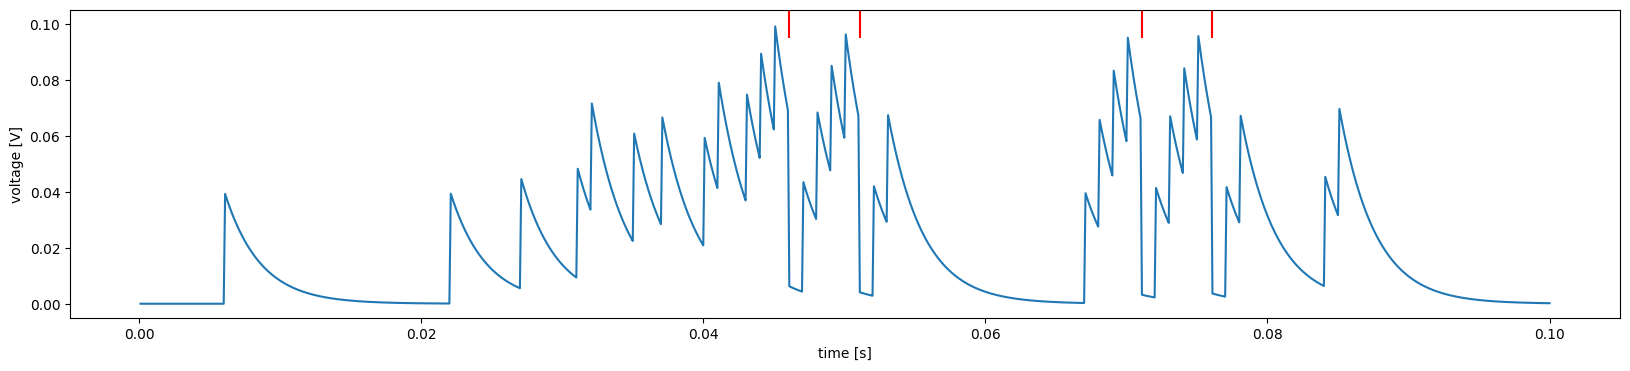

Exact spike times: ['0.046084', '0.051090', '0.071092', '0.076091']


In [3]:
lif_nir()